# Distilroberta-finetuned-financial-news-sentiment-analysis

In [10]:
#!pip install ktrain
#!pip install sentence_transformers

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

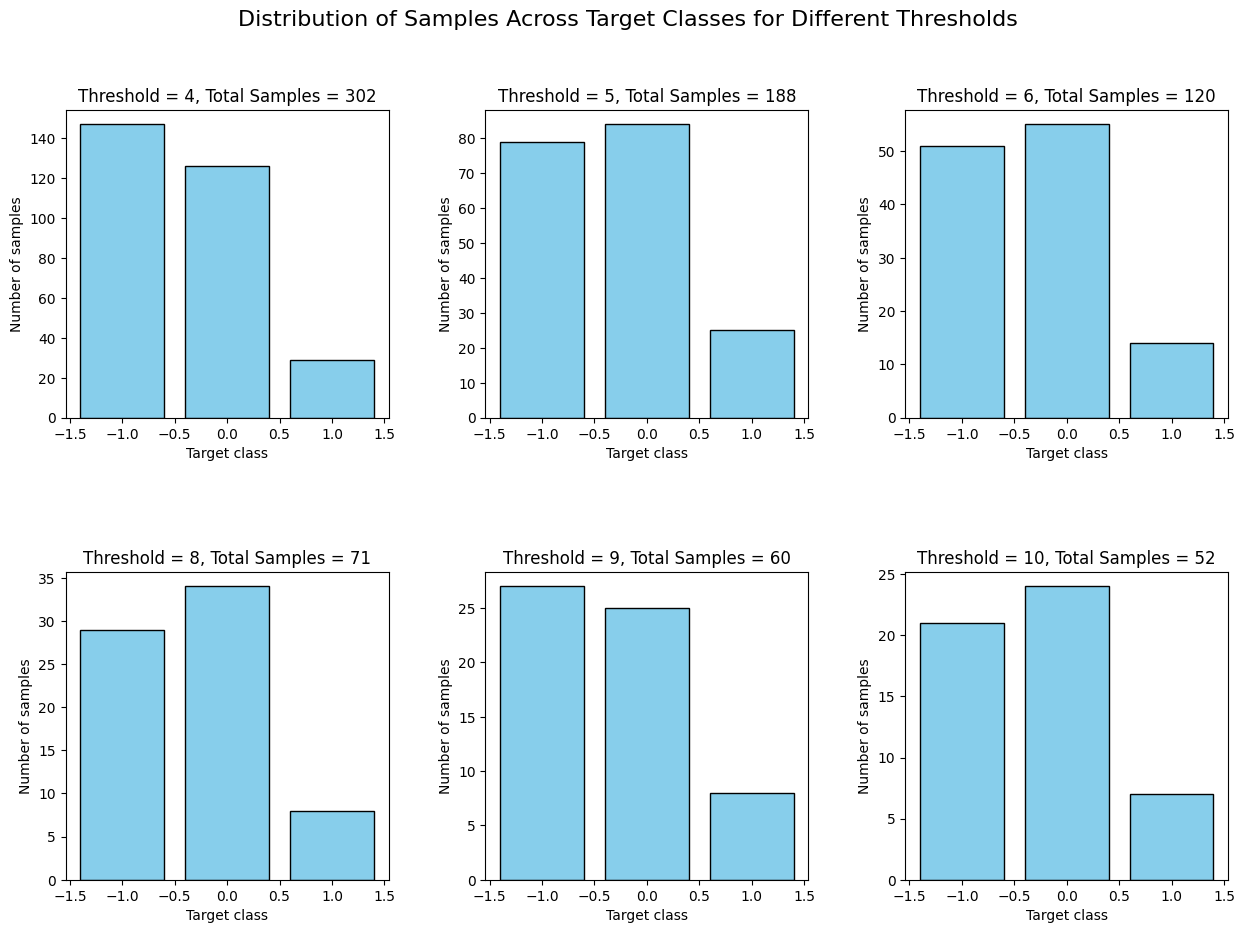

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

threshold = [4,5, 6, 8, 9, 10]
file_list_1 = ["data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

for i, T in enumerate(threshold):
    row_index = i // 3
    col_index = i % 3

    all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold

    for file_name in file_list_1:
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            if len(articles_list) >= T:
                articles_list = articles_list[:T]
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()

We choose T = 4, the dataset is strongly unbalanced

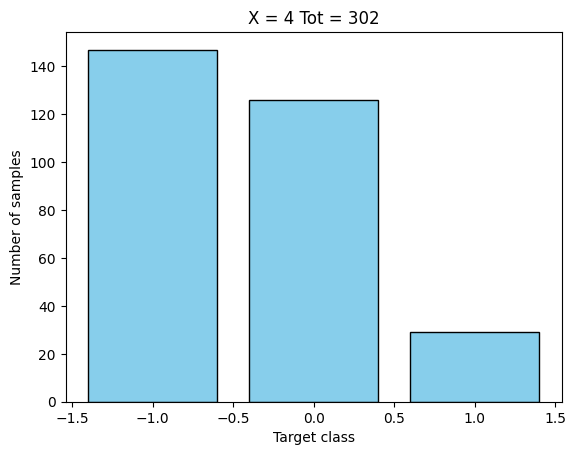

[147, 126, 29]


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
32,CMCSA,Possible Bearish Signals With Comcast Insiders...,Comcast Co. (NASDAQ:CMCSA) Shares Sold by Heri...,Advisory Services Network LLC Reduces Position...,(CMCSA) Trading Report - Stock Traders Daily,,,,,,,0.0,Possible Bearish Signals With Comcast Insiders...
187,CAG,Franklin Resources Inc. Sells 73862 Shares of ...,"Franklin Resources Inc. Sells 73,862 Shares of...",Q1 Rundown: Conagra (NYSE:CAG) Vs Other Shelf-...,"Conagra Brands, Inc. (NYSE:CAG) EVP Charisse B...",,,,,,,-1.0,Franklin Resources Inc. Sells 73862 Shares of ...
29,CINF,(CINF) Long Term Investment Analysis - Stock T...,Cincinnati Financial Unveils Investor Presenta...,Closing Bell: CI Global Infrastructure Pvt Poo...,5 Insurance Stocks to Watch With Impressive Di...,,,,,,,-1.0,(CINF) Long Term Investment Analysis - Stock T...


In [13]:
all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold
T = 4
for file_name in file_list_1:
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set

input_df = input_df.dropna(axis=0)
'''
# We rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

'''
plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = '+ str(T)+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
input_df.sample(n=3)

Now we divide the dataset in training set, validation set and test set

In [14]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

y_train = y_train + 1            
y_test = y_test + 1
y_val = y_val + 1

### Here starts model training

In [15]:
model_name = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
transformer = text.Transformer(model_name, maxlen=512, class_names= np.array([0,1,2]))

In [16]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_val = transformer.preprocess_test(list(x_val["Concatenated Titles"]), list(y_val["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 55
	95percentile : 66
	99percentile : 81


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\utils.py:769: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  "class_names implies classification but targets array contains float(s) instead of integers or strings"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 54
	95percentile : 64
	99percentile : 66


In [17]:
model = transformer.get_classifier()
batch_size = 5                      
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
38/38 [==============================] - 219s 6s/step - loss: 19.5249 - accuracy: 0.3737


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\lroptimize\lrfinder.py:267: UserWarning: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.
  warnings.warn(str(e))




done.
Visually inspect loss plot and select learning rate associated with falling loss


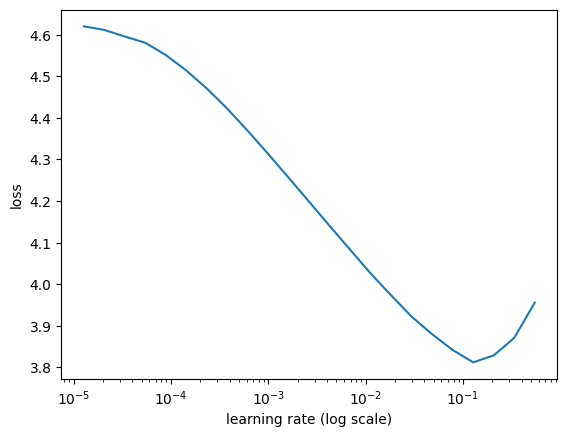

In [18]:
learner.lr_find(show_plot=True,  max_epochs=1)

Probably this model is not meant to trained: as it is fine-tuned already.

In [19]:
learner.fit_onecycle(0.5e-1, 2)



begin training using onecycle policy with max lr of 0.05...
Epoch 1/2
39/39 [==============================] - 259s 6s/step - loss: 5.0794 - accuracy: 0.4010 - val_loss: 2.1566 - val_accuracy: 0.5510
Epoch 2/2
39/39 [==============================] - 259s 7s/step - loss: 3.4460 - accuracy: 0.4271 - val_loss: 1.4403 - val_accuracy: 0.5510


In [20]:
learner.validate(class_names=transformer.get_classes())

2/2 [==============================] - 6s 2s/step
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        27
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00         2

    accuracy                           0.55        49
   macro avg       0.18      0.33      0.24        49
weighted avg       0.30      0.55      0.39        49



c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[27,  0,  0],
       [20,  0,  0],
       [ 2,  0,  0]], dtype=int64)

In [21]:
'''
# let's see some predictions
'''
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
import random as rand
i = rand.randint(0,100)

print(input_df["Ticker"].iloc[i],"\n",\
      "Prediction: \n",\
      predictor.predict(x_test["Concatenated Titles"].iloc[i]),\
      "\nTarget: \n",\
      y_train["Target"].iloc[i])

FMC 
 Prediction: 
 0 
Target: 
 1.0


In [22]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
y_val_pred_labels  = np.zeros( x_val.shape[0])
for i in range(x_val.shape[0]):
    y_val_pred_labels[i] = predictor.predict(x_val["Concatenated Titles"].iloc[i])

y_val_pred_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It always predicts class DOWN... not really good